In [112]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.models import model_from_json
import matplotlib.pyplot as plt
import matplotlib
import brewer2mpl
import numpy as np
import pandas as pd

set3 = brewer2mpl.get_map('Set3', 'qualitative', 6).mpl_colors
%matplotlib inline

# Data Generation


In [287]:
from keras.utils.np_utils import to_categorical
import pandas as pd
import numpy as np
import random
import sys

# fer2013 dataset:
# Training       28709
# PrivateTest     3589
# PublicTest      3589

# emotion labels from FER2013:
emotion = {'Angry': 0, 'Disgust': 1, 'Fear': 2, 'Happy': 3,
           'Sad': 4, 'Surprise': 5, 'Neutral': 6}
emo     = ['Angry', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']

def reconstruct(pix_str, size=(48,48)):
    pix_arr = np.array([element for element in map(int, pix_str.split())])
    return pix_arr.reshape(size)

def emotion_count(y_train, classes, verbose=True):
    emo_classcount = {}
    print('Disgust classified as Angry')
    y_train.loc[y_train == 1] = 0
    classes.remove('Disgust')
    for new_num, _class in enumerate(classes):
        y_train.loc[(y_train == emotion[_class])] = new_num
        class_count = sum(y_train == (new_num))
        if verbose:
            print('{}: {} with {} samples'.format(new_num, _class, class_count))
        emo_classcount[_class] = (new_num, class_count)
    return y_train.values, emo_classcount

def load_data(sample_split=0.3, usage='Training', to_cat=True, verbose=True,
              classes=['Angry','Happy'], filepath='data/fer2013.csv'):
    print(sample_split)
    print(classes)
    print(usage)
    df = pd.read_csv(filepath)
    # print(df.tail()
    print(df.Usage.value_counts())
    df = df[df.Usage == usage]
    frames = []
    classes.append('Disgust')
    for _class in classes:
        class_df = df[df['emotion'] == emotion[_class]]
        frames.append(class_df)
    data = pd.concat(frames, axis=0)
    rows = random.sample(list(data.index), int(len(data) * sample_split))
    data = data.ix[rows]
    print('{} set for {}: {}'.format(usage, classes, data.shape))
    data['pixels'] = data.pixels.apply(lambda x: reconstruct(x))
    x = np.array([mat for mat in data.pixels]) # (n_samples, img_width, img_height)
    X_train = x.reshape(-1, 1, x.shape[1], x.shape[2])
    y_train, new_dict = emotion_count(data.emotion, classes, verbose)
    print(new_dict)
    if to_cat:
        y_train = to_categorical(y_train)
    return X_train, y_train, new_dict

def save_data(X_train, y_train, fname='', folder='data/'):
    np.save(folder + 'X_' + fname, X_train)
    np.save(folder + 'y_' + fname, y_train)


print('Making moves...')
emo = ['Angry', 'Fear', 'Happy',
           'Sad', 'Surprise', 'Neutral']

# Usage Configuration
# usage ='PrivateTest'
for mode in ['PrivateTest', 'Training']:
    X_train, y_train, emo_dict = load_data(sample_split=1, classes=emo, usage=mode, verbose=True)
    print('['+mode+']\tSaving...')
    fname = 'training'
    if mode == 'PrivateTest':
        fname = 'testing'
    save_data(X_train, y_train, fname=fname)
    print(X_train.shape)
    print(y_train.shape)
    print('Done!')


Making moves...
1
['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
PrivateTest
Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64
PrivateTest set for ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral', 'Disgust']: (3589, 3)
Disgust classified as Angry


/Users/andrewwong/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


0: Angry with 546 samples
1: Fear with 528 samples
2: Happy with 879 samples
3: Sad with 594 samples
4: Surprise with 416 samples
5: Neutral with 626 samples
{'Angry': (0, 546), 'Fear': (1, 528), 'Happy': (2, 879), 'Sad': (3, 594), 'Surprise': (4, 416), 'Neutral': (5, 626)}
[PrivateTest]	Saving...
(3589, 1, 48, 48)
(3589, 6)
Done!
1
['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
Training
Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64
Training set for ['Angry', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral', 'Disgust']: (28709, 3)
Disgust classified as Angry
0: Angry with 4431 samples
1: Fear with 4097 samples
2: Happy with 7215 samples
3: Sad with 4830 samples
4: Surprise with 3171 samples
5: Neutral with 4965 samples
{'Angry': (0, 4431), 'Fear': (1, 4097), 'Happy': (2, 7215), 'Sad': (3, 4830), 'Surprise': (4, 3171), 'Neutral': (5, 4965)}
[Training]	Saving...
(28709, 1, 48, 48)
(28709, 6)
Done!


# Training and Preprecessing

In [288]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from sklearn.cross_validation import train_test_split
import numpy as np
import time
import sys

In [289]:
import json
import time

starttime = time.asctime(time.localtime(time.time()))


def save_model(json_string, starttime, dirpath='data/results/'):
    #path = dirpath + str(starttime) + '.json'
    path = dirpath + 'model.json'
    try:
        file = open(path, 'w')
    except FileNotFoundError:
        file = open(path, 'w+')
    file.write(json_string)

def save_config(config, starttime, dirpath='data/results/'):
    path = dirpath + 'config_log.txt'
    file = None
    try:
        file = open(path, 'a')
    except FileNotFoundError:
        file = open(path, 'w')
        
    file.write('%s\n' % str(starttime))
    file.write('%s\n' % str(config))
    
def save_result(starttime, train_val_accuracy, notes, conv_arch, dense, dirpath='data/results/'):
    train_acc = train_val_accuracy['train_acc']
    val_acc = train_val_accuracy['val_acc']
    
    path = dirpath + str(starttime) + '_train_val.txt'
    
    try:
        file = open(path, 'a')
    except FileNotFoundError:
        file = open(path, 'w+')
    file.write(str(train_acc) + '\n')
    file.write(str(val_acc) + '\n')
    

    endtime = time.asctime(time.localtime(time.time()))
    path = dirpath + 'result_log.txt'
    try:
        file = open(path, 'a')
    except FileNotFoundError:
        file = open(path, 'w+')
    file.write(str(starttime) + '--' + str(endtime) + ' comment: ' + notes + '\n')
    file.write(str(conv_arch) + ',' + str(dense) + '\n')
    file.write('Train acc: ' + str(train_acc[-1]) +
        'Val acc: ' + str(val_acc[-1]) +
        'Ratio: ' + str(val_acc[-1] / train_acc[-1]) + '\n')



In [290]:
def describe(X_shape, y_shape, batch_size, dropout, nb_epoch, conv_arch, dense):
    print(' X_train shape: ', X_shape) # (n_sample, 1, 48, 48)
    print(' y_train shape: ', y_shape) # (n_sample, n_categories)
    print('      img size: ', X_shape[2], X_shape[3])
    print('    batch size: ', batch_size)
    print('      nb_epoch: ', nb_epoch)
    print('       dropout: ', dropout)
    print('conv architect: ', conv_arch)
    print('neural network: ', dense)

In [291]:
def logging(model, starttime, batch_size, nb_epoch, conv_arch,dense, dropout,
            X_shape, y_shape, train_acc, val_acc, dirpath):
    now = time.ctime()
    #model.save_weights('data/weights/{}'.format(now))
    model.save_weights('data/weights/model.h5')
    save_model(model.to_json(), now, dirpath)
    save_config(model.get_config(), now, dirpath)
    # def save_result(starttime, train_val_accuracy, notes, conv_arch, dense, dirpath='data/results/'):
    save_result(starttime, {'train_acc':train_acc ,'val_acc': val_acc}, 'No Notes', conv_arch, dense)

In [292]:
# from keras import backend as K
# K.set_image_dim_ordering('tf')

def cnn_architecture(X_train, y_train, conv_arch=[(32,3),(64,3),(128,3)],
                    dense=[64,2], dropout=0.5, batch_size=128, nb_epoch=100, validation_split=0.4, patience=5, dirpath='../data/results/'):
    starttime = time.time()
    X_train = X_train.astype('float32')
    X_shape = X_train.shape
    y_shape = y_train.shape
    describe(X_shape, y_shape, batch_size, dropout, nb_epoch, conv_arch, dense)

    # data augmentation:
    # X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=validation_split)
    # datagen = ImageDataGenerator(rescale=1./255,
    #                              rotation_range=10,
    #                              shear_range=0.2,
    #                              width_shift_range=0.2,
    #                              height_shift_range=0.2,
    #                              horizontal_flip=True)

    # datagen.fit(X_train)
    # model architecture:
    model = Sequential()
    model.add(Conv2D(32,(3, 3), padding="same",activation='relu',input_shape=(1, X_train.shape[2], X_train.shape[3])))
    model.add(Conv2D(32,(3, 3), padding="same", activation='relu'))
    model.add(Conv2D(32,(3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
    model.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_first"))

    model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(6, activation='softmax'))

    # optimizer:
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # set callback:
    callbacks = []
    if patience != 0:
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
        callbacks.append(early_stopping)

    print('Training....')
    # fits the model on batches with real-time data augmentation:
    # hist = model.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
    #                 samples_per_epoch=len(X_train), nb_epoch=nb_epoch, validation_data=(X_test,y_test), callbacks=callbacks, verbose=1)

    '''without data augmentation'''
    hist = model.fit(X_train, y_train, epochs=nb_epoch, batch_size=batch_size,
              validation_split=validation_split, callbacks=callbacks, shuffle=True, verbose=1)

    # model result:
    train_val_accuracy = hist.history
    train_acc = train_val_accuracy['acc']
    val_acc = train_val_accuracy['val_acc']
    print('          Done!')
    print('     Train acc: ', train_acc[-1])
    print('Validation acc: ', val_acc[-1])
    print(' Overfit ratio: ', val_acc[-1]/train_acc[-1])

    logging(model, starttime, batch_size, nb_epoch, conv_arch, dense,
            dropout, X_shape, y_shape, train_acc, val_acc, dirpath)

    return model

In [ ]:
X_fname = 'data/X_training.npy'
y_fname = 'data/y_training.npy'
X_train = np.load(X_fname)
y_train = np.load(y_fname)
print('Loading data...')

cnn_architecture(X_train, y_train, conv_arch=[(32,3),(64,3),(128,3)], dense=[64,2], batch_size=256, nb_epoch=100, dirpath = 'data/results/')


## Loading CNN Model

In [193]:
# load json and create model
json_file = open('data/results/model.json','r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into model
model.load_weights('data/weights/model.h5')

## Data Summary

| FER2013 data | count|
|:-------------|-----:|
|Training      | 28709|
|Private Test  |  3589|
|Public Test   |  3589|

| Training set | count|
|:-------------|-----:|
|Angry         |  4431|
|Fear          |  4097|
|Happy         |  7215|
|Sad           |  4830|
|Surprise      |  3171|
|Neutral       |  4965|

## Model Accuracy

In [194]:
# # import public test:
# X_fname = 'data/X_publictest6_100pct.npy'
# y_fname = 'data/y_publictest6_100pct.npy'
# X = np.load(X_fname)
# y = np.load(y_fname)
# print('Public test set')
# y_labels = [np.argmax(lst) for lst in y]
# counts = np.bincount(y_labels)
# labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
# print(zip(labels, counts))
# # evaluate model on public test set
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# score = model.evaluate(X, y, verbose=0)
# print("model %s: %.2f%%" % (model.metrics_names[1], score[1]*100))

In [255]:
# import private test:
X_fname = 'data/X_testing.npy'
y_fname = 'data/y_testing.npy'
X = np.load(X_fname)
y = np.load(y_fname) # data/y_training.npy
print('Training set')
y_labels = [np.argmax(lst) for lst in y]
counts = np.bincount(y_labels)
labels = ['angry', 'fear', 'happy', 'sad', 'surprise', 'neutral']
print(zip(labels, counts))
# evaluate model on private test set
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = model.evaluate(X, y, verbose=0)
print("model %s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Training set
model acc: 46.93%


## Data Vizualization

In [256]:
def overview(start, end, X):
    fig = plt.figure(figsize=(8,10))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(16,12,i+1)
        ax.imshow(input_img[0,0,:,:], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

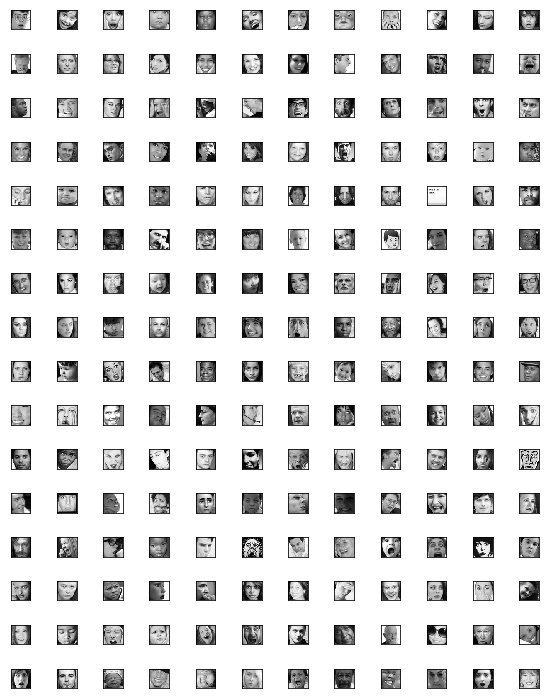

In [257]:
overview(0,191, X) # overview of face data as thumbnails (private)

In [258]:
from keras import backend as K
def plot_filters(layer, x, y):
#     filters = layer.W.get_value()
#     filters = layer.kernel.get_value()
    filters = K.get_value(layer.kernel)
    fig = plt.figure(figsize=(8, 4))
    for j in range(len(filters)):
        ax = fig.add_subplot(y, x, j+1)
        ax.matshow(filters[j][0], cmap = matplotlib.cm.Blues)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.tight_layout()
    return plt

16


AttributeError: 'MaxPooling2D' object has no attribute 'kernel'

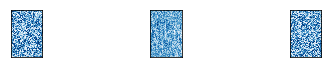

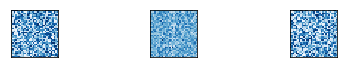

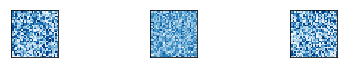

In [259]:
print(len(model.layers))
for i in range(0, len(model.layers) - 1):
    plot_filters(model.layers[i], 4, 4)
# plot_filters(model.layers[0], 4, 4)
# plot_filters(model.layers[4], 8, 8)
# plot_filters(model.layers[10], 16, 8)

(1, 1, 48, 48)


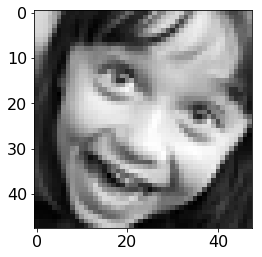

In [260]:
input_img = X[1:2,:,:,:] # subject0
print(input_img.shape)
plt.imshow(input_img[0,0,:,:], cmap='gray')

## Computer Vision

In [261]:
import theano
from numpy import array

def plot_interlayer_outputs(input_img, layer_num1, layer_num2, colormaps=False):

    # output_fn = theano.function([model.layers[layer_num1].input], model.layers[layer_num2].output, allow_input_downcast=True)

    output_fn = K.function([model.layers[layer_num1].input, K.learning_phase()],
                                  [model.layers[layer_num2].output])
    reshape = input_img.reshape(, 1, input_img.shape[1], input_img.shape[2])
    im = output_fn(reshape.tolist()) #filtered image
    
#     data['pixels'] = data.pixels.apply(lambda x: reconstruct(x))
#     x = np.array([mat for mat in data.pixels]) # (n_samples, img_width, img_height)
#     X_train = x.reshape(-1, 1, x.shape[1], x.shape[2])
    
    n_filters = im.shape[1]
    fig = plt.figure(figsize=(12,6))
    for i in range(n_filters):
        ax = fig.add_subplot(n_filters/16,16,i+1)
        if colormaps:
            ax.imshow(im[0,i,:,:], cmap='Blues')#seq_colors[i]
        else:
            ax.imshow(im[0,i,:,:], cmap=matplotlib.cm.gray) #matplotlib.cm.gray
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

SyntaxError: invalid syntax (<ipython-input-261-756d0bc33b2d>, line 10)

In [262]:
plot_interlayer_outputs(input_img, 0, 1, colormaps=True)
# figsize=(12,6)
# ax = fig.add_subplot(n_filters/8,8,i+1)

ValueError: Cannot feed value of shape (1, 1, 48) for Tensor 'conv2d_73_input_1:0', which has shape '(?, 1, 48, 48)'

In [263]:
plot_interlayer_outputs(input_img, 0, 4, colormaps=True) 
# figsize=(6,6)
# ax = fig.add_subplot(n_filters/8,8,i+1)

ValueError: Cannot feed value of shape (1, 1, 48) for Tensor 'conv2d_73_input_1:0', which has shape '(?, 1, 48, 48)'

In [264]:
plot_interlayer_outputs(input_img, 0, 10, colormaps=True) 
# figsize=(12,6)
# ax = fig.add_subplot(n_filters/16,16,i+1)

ValueError: Cannot feed value of shape (1, 1, 48) for Tensor 'conv2d_73_input_1:0', which has shape '(?, 1, 48, 48)'

## Prediction Result

In [265]:
# prediction and true labels
y_prob = model.predict(X, batch_size=32, verbose=0)

y_pred = [np.argmax(prob) for prob in y_prob]
y_true = [np.argmax(true) for true in y]

In [266]:
def plot_subjects(start, end, y_pred, y_true, title=False):

    fig = plt.figure(figsize=(12,12))
    emotion = {0:'Angry', 1:'Fear', 2:'Happy', 3:'Sad', 4:'Surprise', 5:'Neutral'}
    for i in range(int(start), int(end)+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img[0,0,:,:], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel(emotion[y_true[i]], color='#53b3cb',fontsize=12)
        else:
            plt.xlabel(emotion[y_true[i]], fontsize=12)
        if title:
            plt.title(emotion[y_pred[i]], color='blue')
        plt.tight_layout()
    plt.show()

In [267]:
def plot_probs(start,end, y_prob):
    fig = plt.figure(figsize=(12,12))
    for i in range(int(start), int(end)+1):
        input_img = X[i:(i+1),:,:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.bar(np.arange(0,6), y_prob[i], color=set3,alpha=0.5)
        ax.set_xticks(np.arange(0.5,6.5,1))
        labels = ['angry', 'fear', 'happy', 'sad', 'surprise','neutral']
        ax.set_xticklabels(labels, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

In [268]:
def plot_subjects_with_probs(start, end, y_prob):
    iter = (end - start)/6
    for i in np.arange(0,iter):
        plot_subjects(i*6,(i+1)*6-1, y_pred, y_true, title=False)
        plot_probs(i*6,(i+1)*6-1, y_prob)

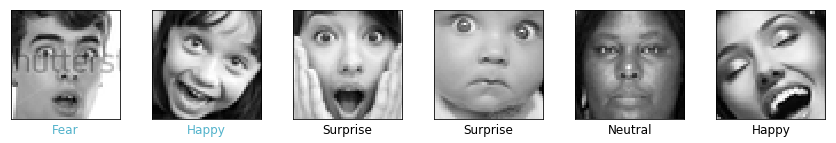

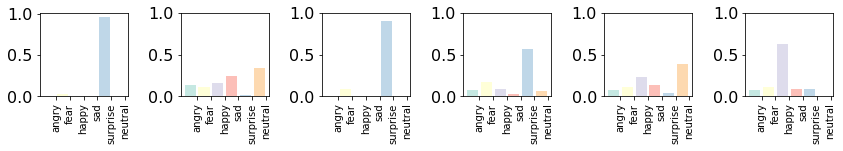

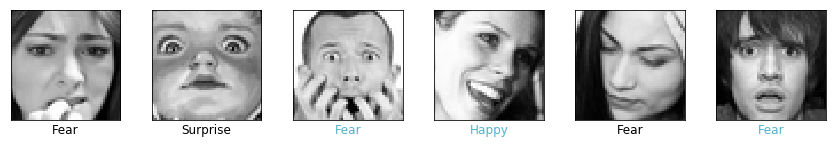

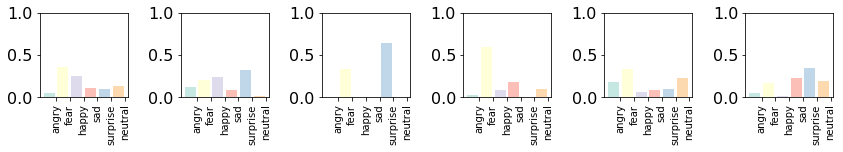

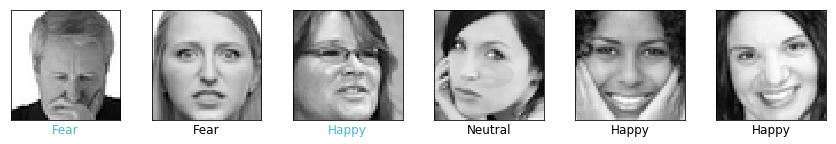

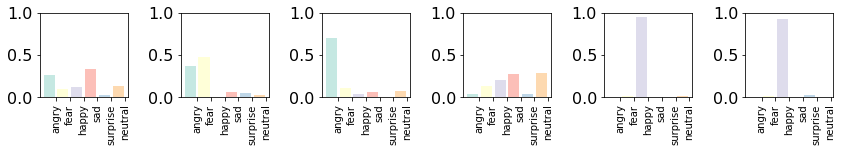

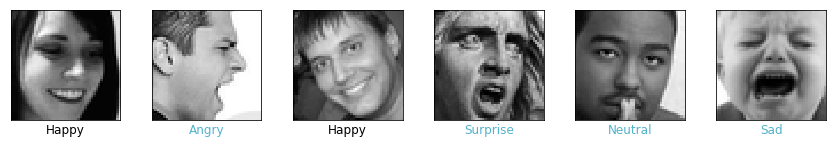

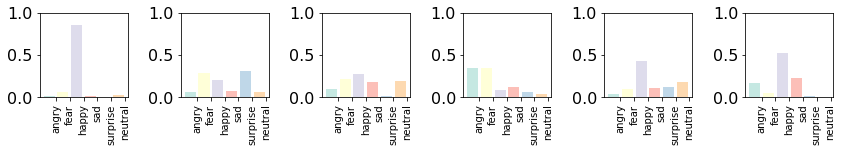

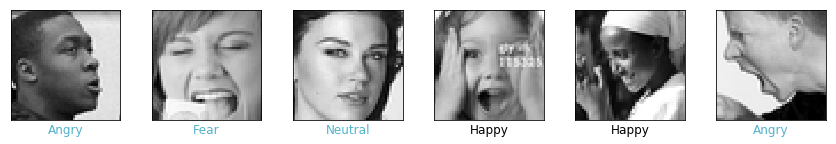

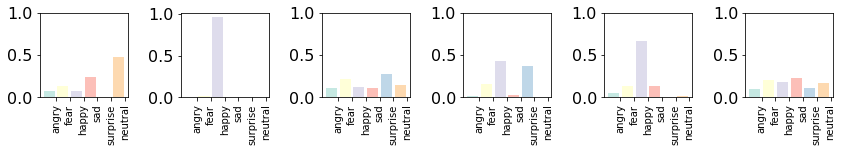

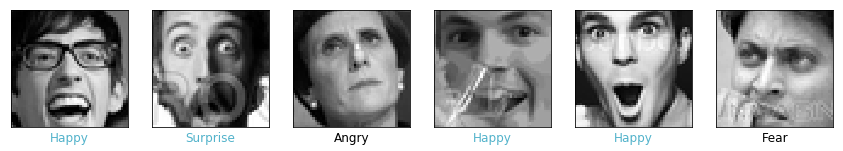

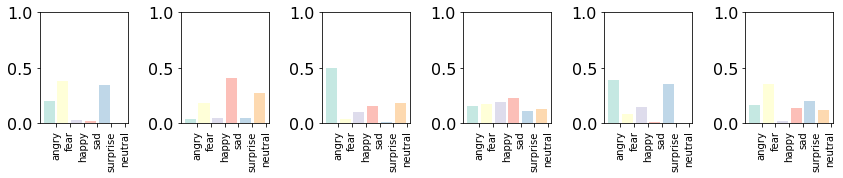

In [269]:
plot_subjects_with_probs(0, 36, y_prob)

In [270]:
y_training = 'data/y_training.npy'
y_testing = 'data/y_testing.npy'

y_training = np.load(y_training)
y_testing = np.load(y_testing)

y_training_labels = [np.argmax(lst) for lst in y_training]
y_testing_labels = [np.argmax(lst) for lst in y_testing]

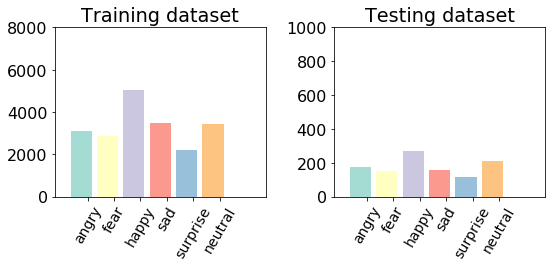

In [271]:
def plot_distribution(y1, y2, data_names, ylims =[1000,1000]): 
    fig = plt.figure(figsize=(8,4))
    ax1 = fig.add_subplot(1,2,1)
    ax1.bar(np.arange(1,7), np.bincount(y1), color=set3, alpha=0.8)
    ax1.set_xticks(np.arange(1.25,7.25,1))
    ax1.set_xticklabels(labels, rotation=60, fontsize=14)
    ax1.set_xlim([0, 8])
    ax1.set_ylim([0, ylims[0]])
    ax1.set_title(data_names[0])
    ax2 = fig.add_subplot(1,2,2)
    ax2.bar(np.arange(1,7), np.bincount(y2), color=set3, alpha=0.8)
    ax2.set_xticks(np.arange(1.25,7.24,1))
    ax2.set_xticklabels(labels, rotation=60, fontsize=14)
    ax2.set_xlim([0, 8])
    ax2.set_ylim([0, ylims[1]])
    ax2.set_title(data_names[1])
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_training_labels, y_testing_labels, ['Training dataset', 'Testing dataset'], ylims =[8000,1000]) 


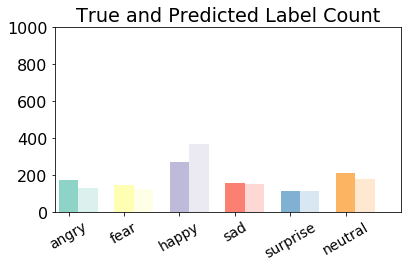

In [272]:
def plot_distribution(y_true, y_pred):
    ind = np.arange(1.5,7,1)  # the x locations for the groups
    width = 0.35
    fig, ax = plt.subplots()
    true = ax.bar(ind, np.bincount(y_true), width, color=set3, alpha=1.0)
    pred = ax.bar(ind + width, np.bincount(y_pred), width, color=set3, alpha=0.3)
    ax.set_xticks(np.arange(1.5,7,1))
    ax.set_xticklabels(labels, rotation=30, fontsize=14)
    ax.set_xlim([1.25, 7.5])
    ax.set_ylim([0, 1000])
    ax.set_title('True and Predicted Label Count')
    plt.tight_layout()
    plt.show()
    
plot_distribution(y_true, y_pred)

## Confusion Matrix

In [273]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(6,6))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,6):
        for j in range(0,6):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    # ax.set_title('Confusion Matrix')
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

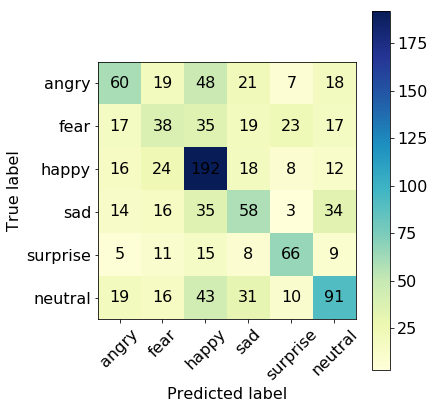

In [274]:
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)

## Classification Metrics

In [275]:
def class_precision(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    col = [cm[j,i] for j in range(0,6)]
    return float(col[i])/sum(col)

def class_recall(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    row = [cm[i,j] for j in range(0,6)]
    return float(row[i])/sum(row)

def class_accuracy(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    tp = cm[i,i]
    fn = sum([cm[i,j] for j in range(0,6) if j != i])
    fp = sum([cm[j,i] for j in range(0,6) if j != i])
    tn = sum([cm[i,j] for j in range(0,6) for i in range(0,6)]) -(tp+fp+fn)
    return float(tp + tn)/sum([tp, fn, fp, tn])

In [276]:
# private test set
for emotion in labels:
    print(emotion.upper())
    print('\t Accuracy = {}'.format(class_accuracy(y_true, y_pred, emotion)))
    print('\tPrecision = {}'.format(class_precision(y_true, y_pred, emotion)))
    print('\t   recall = {}\n'.format(class_recall(y_true, y_pred, emotion)))

ANGRY
	 Accuracy = 0.828996282527881
	Precision = 0.4580152671755725
	   recall = 0.3468208092485549

FEAR
	 Accuracy = 0.8169144981412639
	Precision = 0.3064516129032258
	   recall = 0.2550335570469799

HAPPY
	 Accuracy = 0.7639405204460966
	Precision = 0.5217391304347826
	   recall = 0.7111111111111111

SAD
	 Accuracy = 0.8150557620817844
	Precision = 0.3741935483870968
	   recall = 0.3625

SURPRISE
	 Accuracy = 0.9079925650557621
	Precision = 0.5641025641025641
	   recall = 0.5789473684210527

NEUTRAL
	 Accuracy = 0.8057620817843866
	Precision = 0.5027624309392266
	   recall = 0.43333333333333335



In [277]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, target_names=labels))

             precision    recall  f1-score   support

      angry       0.46      0.35      0.39       173
       fear       0.31      0.26      0.28       149
      happy       0.52      0.71      0.60       270
        sad       0.37      0.36      0.37       160
   surprise       0.56      0.58      0.57       114
    neutral       0.50      0.43      0.47       210

avg / total       0.46      0.47      0.46      1076



In [278]:
n = len(y_true)
y_fir = []
y_sec = []
y_trd = []
for i in range(n):
    if y_true[i] == np.argsort(y_prob[i])[-1]:
        y_fir.append([i, y_true[i]])
    if y_true[i] == np.argsort(y_prob[i])[-2]:
        y_sec.append([i, y_true[i]])
    if y_true[i] == np.argsort(y_prob[i])[-3]:
        y_trd.append([i, y_true[i]])
print(float(len(y_fir))/n)
print(float(len(y_sec))/n)
print(float(len(y_trd))/n)

0.46933085501858735
0.19052044609665428
0.13568773234200743


In [279]:
misclass = [float(len(y_fir))/n, float(len(y_sec))/n, float(len(y_trd))/n]

In [280]:
len(y_sec)/(len(y_true)*0.58)

0.3284835277528522

In [281]:
len(y_true)*0.58

624.0799999999999

(array([ 28.,   0.,  54.,   0.,  29.,   0.,  40.,   0.,  12.,  42.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ]),
 <a list of 10 Patch objects>)

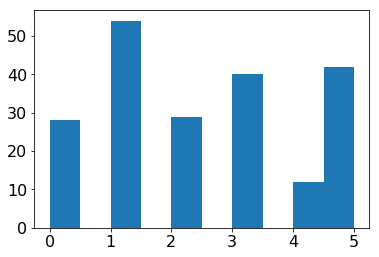

In [282]:
plt.hist([pair[1] for pair in y_sec])

In [285]:
from sklearn.metrics import hamming_loss
hamming_loss(y_true, y_pred)

0.5306691449814126

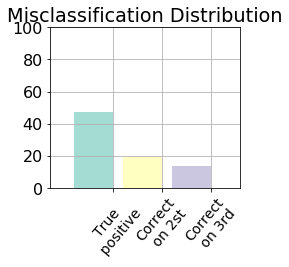

In [286]:
def plot_misclass_distribution(y, tags): 
    fig = plt.figure(figsize=(4,4))
    ax1 = fig.add_subplot(1,1,1)
    ax1.bar(np.arange(1,len(y)+1), np.array(y)*100, color=set3, alpha=0.8)
    ax1.set_xticks(np.arange(1.40,len(y)+1.40,1))
    ax1.set_xticklabels(tags, rotation=50, fontsize=14)
    ax1.set_xlim([.1, len(y)+1])
    ax1.set_ylim([0,100])
    ax1.grid(True)
    ax1.set_title('Misclassification Distribution')
    plt.tight_layout()
    plt.show()
tags = ['True\n positive','Correct\n on 2st','Correct\n on 3rd']
plot_misclass_distribution(misclass, tags)